
开始硬件推理，样本编号: 8

预测结果: 1, 实际标签: 1, 用时: 2.224 ms


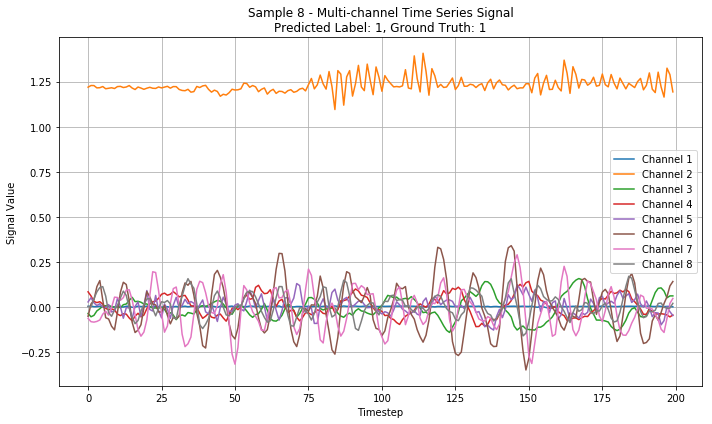

In [17]:
import time
import numpy as np
from pynq import Overlay, allocate
import pynq.lib.dma
import random
import matplotlib.pyplot as plt

# 加载硬件 Overlay 和 DMA
overlay = Overlay('/home/xilinx/jupyter_notebooks/lstm/vivado_mcc5/lstm_mcc5_50MHz.bit')
dma = overlay.axi_dma_0

# ==== 加载测试数据 ====
inputs = np.loadtxt('/home/xilinx/jupyter_notebooks/lstm/data_mcc5/test_10_inputs.csv', delimiter=",").astype(np.float32)  # shape: (10, 200, 8)
labels = np.loadtxt('/home/xilinx/jupyter_notebooks/lstm/data_mcc5/test_10_labels.csv', delimiter=",").astype(int)

# 只选一个随机样本
idx = random.randint(0, inputs.shape[0] - 1)
sample_2d = inputs[idx].reshape(200, 8)  # 显式转换为 (200, 8)

sample_flat = sample_2d.reshape(1600).astype(np.float32)



# 初始化缓冲区
inp_buf = allocate(shape=(1600,), dtype=np.float32)
out_buf = allocate(shape=(10,), dtype=np.float32)

np.copyto(inp_buf, sample_flat)

print(f"\n开始硬件推理，样本编号: {idx}\n")

# 开始计时
t0 = time.time()
dma.sendchannel.transfer(inp_buf)
dma.recvchannel.transfer(out_buf)
dma.sendchannel.wait()
dma.recvchannel.wait()
t1 = time.time()

# 获取推理结果
hw_time = t1 - t0
out_list = out_buf.tolist()
predicted_class = out_list.index(max(out_list))

print(f"预测结果: {predicted_class}, 实际标签: {labels[idx]}, 用时: {hw_time*1000:.3f} ms")

# ==== 可视化样本 ====
plt.figure(figsize=(10, 6))
for ch in range(8):  # 8-channel signal
    plt.plot(sample_2d[:, ch], label=f"Channel {ch+1}")
plt.title(f"Sample {idx} - Multi-channel Time Series Signal\nPredicted Label: {predicted_class}, Ground Truth: {labels[idx]}")
plt.xlabel("Timestep")
plt.ylabel("Signal Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
